# I. Load libraries and dataset

In [2]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, make_scorer
from sklearn.metrics import confusion_matrix
import optuna
from sklearn.metrics import classification_report


warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath("../Sources"))
from preprocessing import preprocess_pipeline

In [3]:
train = pd.read_csv('..\Datasets\Copy of churn-bigml-80.csv')
test = pd.read_csv('..\Datasets\Copy of churn-bigml-20.csv')

# II. Model

## 1. Train

In [4]:
X_train, y_train, X_test, y_test = preprocess_pipeline(train, test, model='lightgbm')

In [5]:
f1_scorer = make_scorer(f1_score, average='macro') 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = lgb.LGBMClassifier(random_state=42, verbosity=-1)

scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_scorer)

print("F1 scores on each fold:", scores)
print("Mean F1 score:", scores.mean())

F1 scores on each fold: [0.96489861 0.97034494 0.96704815 0.96705165 0.9692482 ]
Mean F1 score: 0.9677183106939136


## 2. Optimizing

In [6]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'num_leaves': trial.suggest_int('num_leaves', 7, 255),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
        'verbosity': -1
    }

    model = lgb.LGBMClassifier(**params)
    
    score = cross_val_score(model, X_train, y_train, scoring=f1_scorer, cv=cv, n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
print(study.best_trial)
print("Best parameters:", study.best_params)

[I 2025-05-19 11:03:23,318] A new study created in memory with name: no-name-c86fe6d3-79d3-4fa5-b49a-85a94d64e34f
[I 2025-05-19 11:04:40,014] Trial 0 finished with value: 0.9729962231575456 and parameters: {'learning_rate': 0.16340604100016348, 'n_estimators': 400, 'max_depth': 12, 'num_leaves': 247, 'min_child_samples': 67, 'subsample': 0.5757881058416625, 'colsample_bytree': 0.5100558855247956}. Best is trial 0 with value: 0.9729962231575456.
[I 2025-05-19 11:06:16,655] Trial 1 finished with value: 0.9708004475723883 and parameters: {'learning_rate': 0.17787623631233987, 'n_estimators': 549, 'max_depth': 13, 'num_leaves': 35, 'min_child_samples': 91, 'subsample': 0.5921849276006006, 'colsample_bytree': 0.6084291092770724}. Best is trial 0 with value: 0.9729962231575456.
[I 2025-05-19 11:08:48,016] Trial 2 finished with value: 0.9740943114506502 and parameters: {'learning_rate': 0.14742450506890614, 'n_estimators': 759, 'max_depth': 15, 'num_leaves': 246, 'min_child_samples': 8, 'subs

Best trial:
FrozenTrial(number=22, state=1, values=[0.9780460820017479], datetime_start=datetime.datetime(2025, 5, 19, 11, 11, 56, 638631), datetime_complete=datetime.datetime(2025, 5, 19, 11, 12, 2, 616434), params={'learning_rate': 0.05479309042905244, 'n_estimators': 686, 'max_depth': 12, 'num_leaves': 218, 'min_child_samples': 31, 'subsample': 0.6305121780847327, 'colsample_bytree': 0.5358983724249645}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.3, log=True, low=0.001, step=None), 'n_estimators': IntDistribution(high=1000, log=False, low=50, step=1), 'max_depth': IntDistribution(high=15, log=False, low=3, step=1), 'num_leaves': IntDistribution(high=255, log=False, low=7, step=1), 'min_child_samples': IntDistribution(high=100, log=False, low=5, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None)}, trial_id=

After optimization, the macro F1 score slightly increased.

## 3. Retrain and test

Classification Report:

              precision    recall  f1-score   support

           0     0.9776    0.9930    0.9853       572
           1     0.9535    0.8632    0.9061        95

    accuracy                         0.9745       667
   macro avg     0.9656    0.9281    0.9457       667
weighted avg     0.9742    0.9745    0.9740       667



<Axes: >

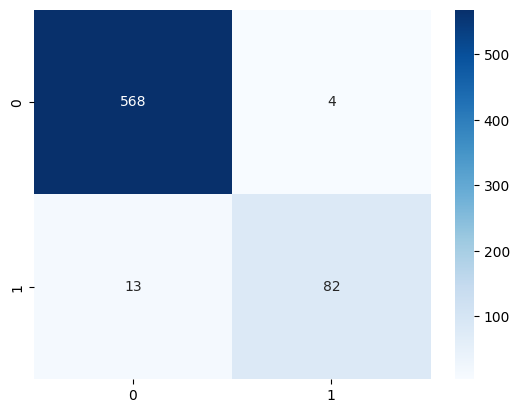

In [7]:
best_model = lgb.LGBMClassifier(**study.best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')

The recall score for class 1 on the test set is relatively high at 0.86, indicating that 86% of churned customers were correctly predicted.

## 4. Feature importance 

In [8]:
importances = best_model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print(importance_df.head(10))

                   Feature  Importance
30              State_freq        3348
29            Total charge        2473
28        intl_calls_ratio        2370
21  avg_intl_call_duration        2352
22           total_minutes        2241
19   avg_eve_call_duration        2177
27             total_calls        2044
5        Total day minutes        2025
6          Total day calls        1892
14      Total intl minutes        1877


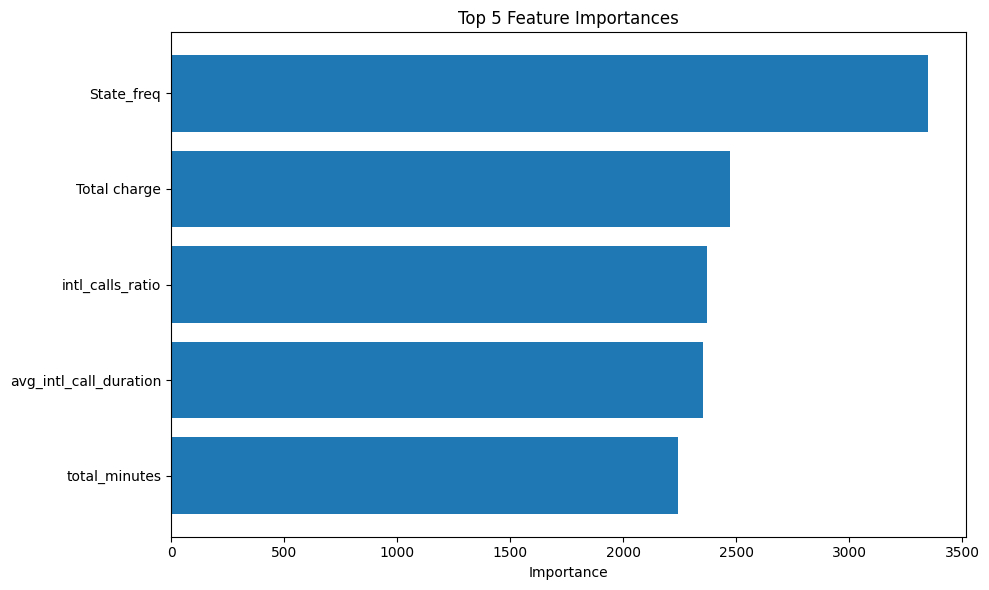

In [9]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:5][::-1], importance_df['Importance'][:5][::-1])
plt.xlabel("Importance")
plt.title("Top 5 Feature Importances")
plt.tight_layout()
plt.show()

The five features with the greatest impact are 'State', 'Total charge', 'intl_calls_ratio', 'avg_intl_call_duration' and 'total_minutes'